# Import libraries

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from dirrac.data.synthetic_data import DataSynthesizer
from dirrac.classifier.logistic import logistic_classifier
from dirrac.optim.opt import Optimization
from utils import cal_validity

In [11]:
if not os.path.exists('result/figure7/'):
    os.makedirs('result/figure7/')

# Synthesize data and train original classifier

In [12]:
# Synthesize data
mean_0 = np.ones(2) * (-3)
mean_1 = np.ones(2) * 3
cov_0 = cov_1 = np.identity(2)
n = 1000
p = [0.4, 0.2, 0.4]

sd = DataSynthesizer(mean_0, cov_0, mean_1, cov_1, n)
features, labels = sd.synthesize_modes_data(100, [0.4, 0.2, 0.4], [0.1, 0.1])

In [13]:
# Train
all_coef = np.zeros((101, 2))
for i in range(101):
    coef = logistic_classifier(features[i], labels[i])[1].T
    all_coef[i] = np.squeeze(coef)

# Get theta
mean_shift = all_coef[1:41]
cov_shift = all_coef[41:61]
both_shift = all_coef[61:101]

theta = np.zeros((3, 2))
sigma = np.zeros((3, 2, 2))

theta[0], sigma[0] = np.mean(mean_shift, axis=0), np.cov(mean_shift.T)
theta[1], sigma[1] = np.mean(cov_shift, axis=0), np.cov(cov_shift.T)
theta[2], sigma[2] = np.mean(both_shift, axis=0), np.cov(both_shift.T)

In [14]:
# Train a classifier
X_train, X_test, y_train, y_test = train_test_split(features[0], labels[0], test_size=0.1, random_state=42)

# Train and get theta
clf, coef = logistic_classifier(X_train, y_train)

yhat = clf.predict(X_test)
X_recourse = X_test[yhat == 0]

# Define function

In [15]:
# Optimization module
delta_l = [1e-3, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]
k = 3
dim = 2
rho = np.array([0, 0, 0])
lmbda = 0.7
zeta = 1

features_shift, labels_shift = sd.synthesize_modes_data(1000, [0.1, 0.8, 0.1], [0.2, 0.2])
clf_shift = [logistic_classifier(features_shift[i + 1], labels_shift[i + 1])[0] for i in range(len(features_shift) - 1)]

def recourse_delta_param(delta, opt, num_samples=10):
    all_x_opt = np.zeros((num_samples, 2))
    for i in range(num_samples):
        out = opt.recourse_action(X_recourse[i], 10)
        f_opt, x_opt = out
        all_x_opt[i] = x_opt
        
    all_val = np.zeros(len(features_shift) - 1)
    for i in range(len(features_shift) - 1):
        # Train and get theta
        yhat = clf_shift[i].predict(all_x_opt)
        all_val[i] = cal_validity(yhat)
    
    return np.mean(all_val), np.std(all_val)

# Non-parametric mixture

In [16]:
orig_model_mixture_val, orig_model_mixture_std = np.zeros(len(delta_l)), np.zeros(len(delta_l))
for i in range(len(delta_l)):
    print(f"Start delta {delta_l[i]}")
    opt = Optimization(delta_l[i], k, dim, p, theta, sigma, rho, lmbda, zeta, gaussian=False)
    orig_model_mixture_val[i], orig_model_mixture_std[i] = recourse_delta_param(delta_l[i], opt)

Start delta 0.001

Interrupt request received
Start delta 0.02
Start delta 0.04
Start delta 0.06
Start delta 0.08
Start delta 0.1
Start delta 0.12
Start delta 0.14
Start delta 0.16
Start delta 0.18
Start delta 0.2


In [17]:
orig_model_mixture_val, orig_model_mixture_std

(array([0.8442, 0.9207, 0.9453, 0.9569, 0.9653, 0.9717, 0.977 , 0.9816,
        0.9847, 0.9872, 0.9885]),
 array([0.18683244, 0.1110023 , 0.08317397, 0.07356895, 0.06516065,
        0.05629485, 0.04828043, 0.04100537, 0.03682268, 0.03340898,
        0.03190219]))

# Non-parametric mixture worst case

# Gaussian mixture

In [ ]:
gaussian_mixture_val, gaussian_mixture_std = np.zeros(len(delta_l)), np.zeros(len(delta_l))
for i in range(len(delta_l)):
    print(f"Start delta {delta_l[i]}")
    opt = Optimization(delta_l[i], k, dim, p, theta, sigma, rho, lmbda, zeta, gaussian=True, model_type='mixture')
    gaussian_mixture_val[i], gaussian_mixture_std[i] = recourse_delta_param(delta_l[i], opt)

In [ ]:
gaussian_mixture_val, gaussian_mixture_std

# Gaussian worst case

# Visualization

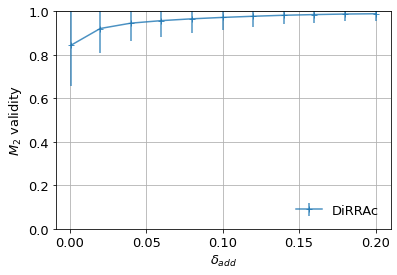

In [18]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots()
ax.errorbar(delta_l, orig_model_mixture_val, orig_model_mixture_std, label='DiRRAc', marker='+', alpha=0.8)

ax.set(xlabel='$\delta_{add}$', ylabel='$M_{2}$ validity')
ax.grid()
ax.legend(loc='lower right', frameon=False)
ax.set_ylim([0, 1])

plt.savefig('result/figure7/delta_add_DiRRAc-NM.pdf', dpi=400, transparent=True)
plt.show()

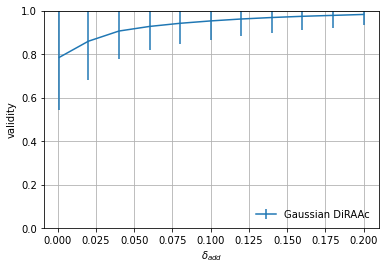

In [12]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots()
ax.errorbar(delta_l, gaussian_mixture_val, gaussian_mixture_std, label='Gaussian DiRAAc')

ax.set(xlabel='$\delta_{add}$', ylabel='validity')
ax.grid()
ax.legend(loc='lower right', frameon=False)
ax.set_ylim([0, 1])

plt.savefig('result/figure7/delta_add_DiRAAc-GM.pdf', transparent=True)
plt.show()